In [1]:
# Dataset link: https://github.com/mwritescode/slither-audited-smart-contracts/tree/main
!pip install datasets[vision]
!pip install hexbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00


In [2]:
import re
import pandas as pd
import seaborn as sns
from hexbytes import HexBytes
import matplotlib.pyplot as plt
from datasets import load_dataset

train_set = load_dataset("mwritescode/slither-audited-smart-contracts", 'big-multilabel', split='train', ignore_verifications=True)
test_set = load_dataset("mwritescode/slither-audited-smart-contracts", 'big-multilabel', split='test', ignore_verifications=True)
val_set = load_dataset("mwritescode/slither-audited-smart-contracts", 'big-multilabel', split='validation', ignore_verifications=True)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2096: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/79641 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/15972 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10861 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/load.py:2096: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


In [3]:
# pre-processing functions
def remove_comments(string):
    pattern = r"(\".*?\"|\'.*?\')|(/\*.*?\*/|//[^\r\n]*$)"
    # first group captures quoted strings (double or single)
    # second group captures comments (//single-line or /* multi-line */)
    regex = re.compile(pattern, re.MULTILINE|re.DOTALL)
    def _replacer(match):
        # if the 2nd group is not None, then we have captured a real comment string.
        if match.group(2) is not None:
            return ""
        else: # otherwise, we will return the 1st group
            return match.group(1)
    return regex.sub(_replacer, string)

def get_lenghts(example):
    code = remove_comments(example['source_code'])
    example['sourcecode_len'] = len(code.split())
    example['bytecode_len'] = len(HexBytes(example['bytecode']))
    return example

In [5]:
COLS_TO_REMOVE = ['source_code', 'bytecode']

LABELS = {0:'access-control', 1:'arithmetic', 2:'other', 3:'reentrancy', 4:'safe', 5:'unchecked-calls'}

datasets = []
for split in [train_set, test_set, val_set]:
    split_df = pd.DataFrame(split.map(get_lenghts, remove_columns=COLS_TO_REMOVE)).explode('slither')
    split_df['slither'] = split_df['slither'].map(LABELS)
    datasets.append(split_df)

concatenated = pd.concat([split.assign(dataset=split_name) for split, split_name in zip(datasets, ['train', 'test', 'val'])])

Map:   0%|          | 0/79641 [00:00<?, ? examples/s]

Map:   0%|          | 0/15972 [00:00<?, ? examples/s]

Map:   0%|          | 0/10861 [00:00<?, ? examples/s]

In [6]:
concatenated.head()

,address,slither,sourcecode_len,bytecode_len,dataset
0,0x006699d34AA3013605d468d2755A2Fe59A16B12B,arithmetic,973,5887,train
1,0x00c83aeCC790e8a4453e5dD3B0B4b3680501a7A7,other,10705,13263,train
1,0x00c83aeCC790e8a4453e5dD3B0B4b3680501a7A7,arithmetic,10705,13263,train
1,0x00c83aeCC790e8a4453e5dD3B0B4b3680501a7A7,reentrancy,10705,13263,train
2,0x010c5322d78c88ca18282b0a072a8913648b3038,safe,193,1683,train


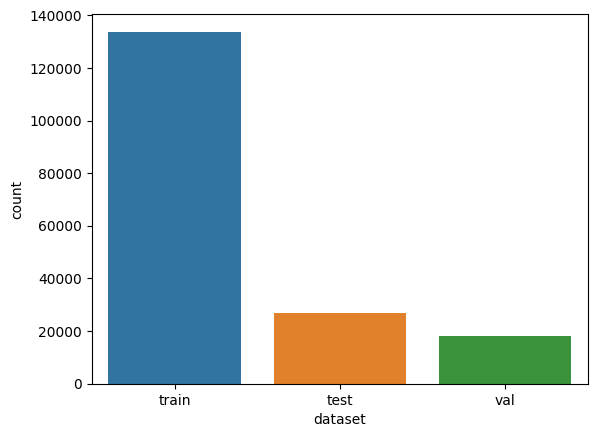

In [7]:
# check the distribution between classes
sns.countplot(x='dataset', data=concatenated)
plt.show()

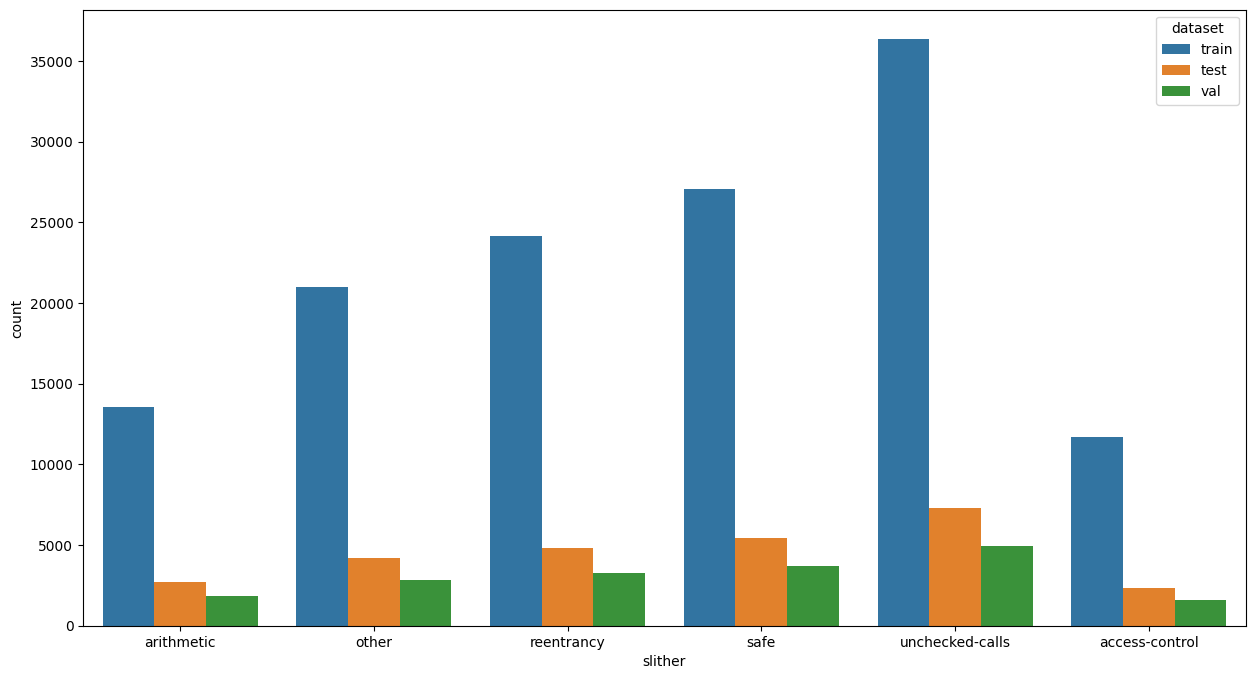

In [8]:
# distribution between classes in each split
_, ax = plt.subplots(figsize=(15, 8))
sns.countplot(x='slither', data=concatenated, hue='dataset', ax=ax)

plt.show()

In [9]:
# drop the labels and duplicates
concatenated = concatenated.drop('slither', axis='columns')
concatenated = concatenated[~concatenated['address'].duplicated(keep='first')].reset_index()

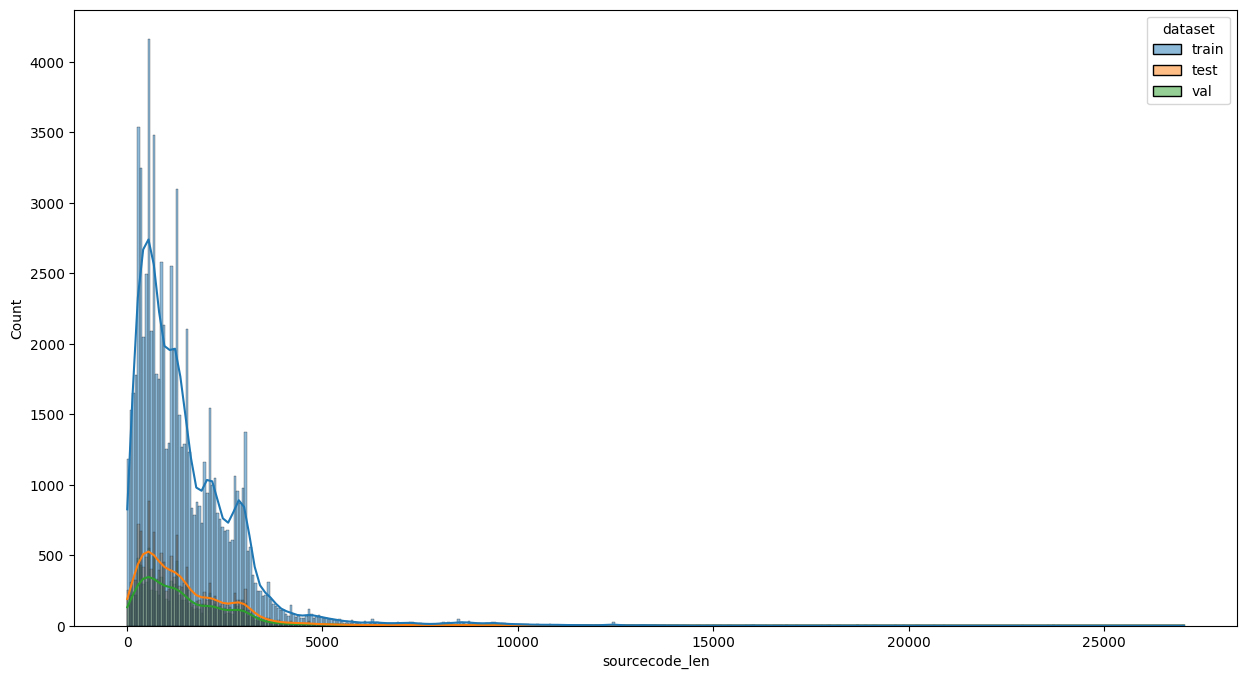

In [13]:
# source code length
_, ax = plt.subplots(figsize=(15, 8))
sns.histplot(data=concatenated, x="sourcecode_len", kde=True, hue='dataset', ax=ax)
plt.show()

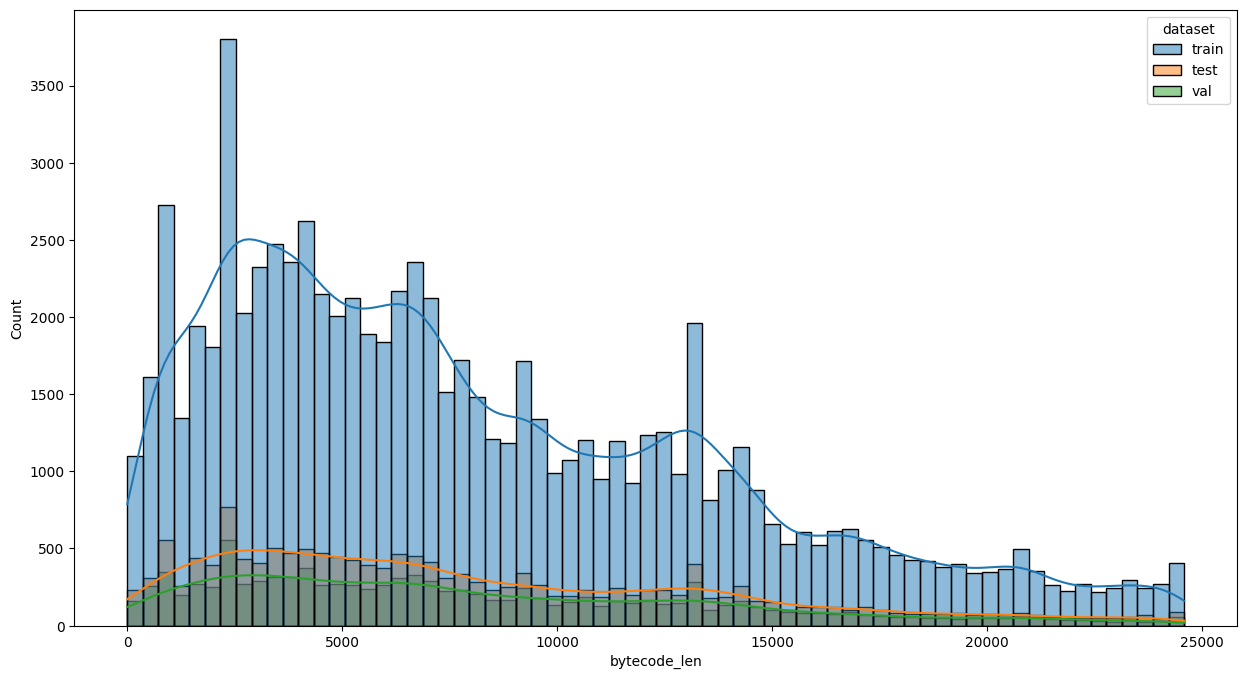

In [14]:
# bytecode length
_, ax = plt.subplots(figsize=(15, 8))
sns.histplot(data=concatenated, x="bytecode_len", kde=True, hue='dataset', ax=ax)
plt.show()

In [15]:
# the number of smart contracts without the bytecode
empty_bytecodes = concatenated[concatenated['bytecode_len'] == 0]['dataset'].value_counts()
empty_bytecodes

train    227
test      51
val       30
Name: dataset, dtype: int64

In [16]:
# the percentage of smart contracts without the bytecode
empty_bytecodes / concatenated['dataset'].value_counts()

train    0.002850
test     0.003193
val      0.002762
Name: dataset, dtype: float64